For the tabular portion of the multimodal probabilistic M1 fusion, Gaussian Process is used, as it is particularly effective in capturing trends in time-series data, even with a small and irregular dataset. Gaussian Process is a stochastic learning method that learns the transition probability in a continuous time-scale by conditioning each discrete time-series data point with interpolated time intervals.

In [1]:
import numpy as np
import pandas as pd
import sys
from pathlib import Path
import torch
import torch.nn as nn
import gpytorch
import matplotlib.pyplot as plt
from gpytorch.kernels import ScaleKernel, MaternKernel, RBFKernel, IndexKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from sklearn.metrics import mean_squared_error, r2_score

For train-test split, it is done by unique patient IDs, as each row in the CSV is not a unique entry, but a series of rows for each patient ID is. Thus, the corresponding y (outcome) only is the FVC value in the last recorded week for each patient. 

Then, numerical features are normalized to ensure their equal weightage, followed by conversion to pyTorch tensors.



In [2]:
repo_root = Path.cwd().parent
sys.path.insert(0, str(repo_root))

from preprocessing.tabular_preprocessing import train_df, val_df

Now that the preprocessing is complete, model is built with separate kernels for the time series, and each categorical feature.

In [3]:
X_time_train = torch.tensor(train_df[["Weeks_scaled"]].values, dtype=torch.float32)
X_age_train = torch.tensor(train_df[["Age"]].values, dtype=torch.float32)

sex_map = {k:i for i,k in enumerate(train_df["Sex"].astype("category").cat.categories)}
smk_map = {k:i for i,k in enumerate(train_df["SmokingStatus"].astype("category").cat.categories)}
sex_train = torch.tensor(train_df["Sex"].map(sex_map).values, dtype=torch.long).unsqueeze(-1)
smk_train = torch.tensor(train_df["SmokingStatus"].map(smk_map).values, dtype=torch.long).unsqueeze(-1)

y_train = torch.tensor(train_df["FVC_scaled"].values, dtype=torch.float32)


In [4]:
class MixedKernel(nn.Module):
    has_lengthscale = False
    def __init__(self):
        super().__init__()
        self.time = ScaleKernel(MaternKernel(nu=1.5))
        self.age  = ScaleKernel(RBFKernel())

        self.sex  = IndexKernel(num_tasks=len(sex_map), rank=2)
        self.smk  = IndexKernel(num_tasks=len(smk_map), rank=2)

    def forward(self, x_time, x_age, x_sex, x_smk, diag=False, **params):
        Kt = self.time(x_time, x_time, diag=diag)
        Ka = self.age(x_age,  x_age,  diag=diag)

        Ks  = self.sex(x_sex,  x_sex)
        Km  = self.smk(x_smk,  x_smk)

        Kdemo = Ka + Ks + Km
        return Kt * Kdemo 
    

class GPM1(gpytorch.models.ExactGP):
    def __init__(self, Xt, Xage, Xsex, Xsmk, y, likelihood):
        super().__init__(train_inputs=(Xt, Xage, Xsex, Xsmk), train_targets=y, likelihood=likelihood)
        self.mean_module = ConstantMean()
        self.covar_module = MixedKernel()

    def forward(self, Xt, Xage, Xsex, Xsmk):
        mean = self.mean_module(torch.cat([Xt, Xage], dim=-1)) 
        covar = self.covar_module(Xt, Xage, Xsex, Xsmk)
        return gpytorch.distributions.MultivariateNormal(mean, covar)

likelihood = GaussianLikelihood()
M1 = GPM1(X_time_train, X_age_train, sex_train, smk_train, y_train, likelihood)

M1.train(); likelihood.train()
optimizer = torch.optim.Adam(M1.parameters(), lr=0.05)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, M1)

for i in range(200):  
    optimizer.zero_grad()
    output = M1(*M1.train_inputs)
    loss = -mll(output, y_train)
    loss.backward()
    optimizer.step()


M1.eval(); likelihood.eval()

Xc_val  = torch.tensor(val_df[["Weeks_scaled","Age"]].values, dtype=torch.float32)
sex_val = torch.tensor(val_df["Sex"].map(sex_map).values, dtype=torch.long).unsqueeze(-1)
smk_val = torch.tensor(val_df["SmokingStatus"].map(smk_map).values, dtype=torch.long).unsqueeze(-1)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    X_time_val = torch.tensor(val_df[["Weeks_scaled"]].values, dtype=torch.float32)
    X_age_val  = torch.tensor(val_df[["Age"]].values,          dtype=torch.float32)
    pred = likelihood(M1(X_time_val, X_age_val, sex_val, smk_val))   
    y_mean = pred.mean.numpy()
    y_std  = pred.variance.sqrt().numpy()

c:\Users\rlaal\AppData\Local\Programs\Python\Python313\Lib\site-packages\linear_operator\utils\interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:656.)
  summing_matrix = cls(summing_matrix_indices, summing_matrix_values, size)


RMSE: 0.8933, R²: -0.0559


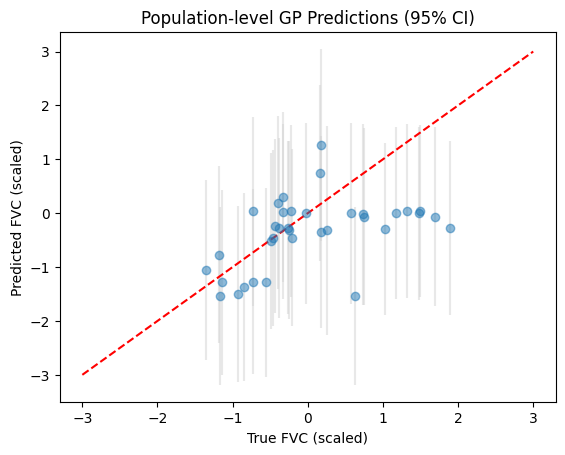

In [54]:
M1.eval()
likelihood.eval()

X_time_val = torch.as_tensor(val_df[["Weeks_scaled"]].values, dtype=torch.float32)
X_age_val  = torch.as_tensor(val_df[["Age"]].values,          dtype=torch.float32)
sex_val    = torch.as_tensor(val_df["Sex"].map(sex_map).values, dtype=torch.long).unsqueeze(-1)
smk_val    = torch.as_tensor(val_df["SmokingStatus"].map(smk_map).values, dtype=torch.long).unsqueeze(-1)

y_true = torch.as_tensor(val_df["FVC_scaled"].values, dtype=torch.float32)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    pred = likelihood(M1(X_time_val, X_age_val, sex_val, smk_val))

y_mean = pred.mean.cpu().numpy()
y_std  = pred.variance.sqrt().cpu().numpy()
y_true = y_true.cpu().numpy()

rmse = np.sqrt(mean_squared_error(y_true, y_mean))
r2   = r2_score(y_true, y_mean)
print(f"RMSE: {rmse:.4f}, R²: {r2:.4f}")


plt.figure()
plt.errorbar(y_true, y_mean, yerr=2*y_std, fmt='o', alpha=0.5, ecolor='lightgray')
plt.plot([-3,3],[-3,3],'r--')  # 1:1 line if still scaled
plt.xlabel("True FVC (scaled)")
plt.ylabel("Predicted FVC (scaled)")
plt.title("Population-level GP Predictions (95% CI)")
plt.show()


It appears to be that the model does not capture any patterns present in the given data, which is most likely because one kernel for time offset was shared by all points across different patients, which did not allow the model to take individual patient's variance into account. To address this problem, a new kernel method is implemented:
1. Mean function is no longer the global linear mean, but a mixed-effects mean that captures patient differences
2. Covariance term now includes an additional index kernel on patient IDS which adds extra covarariance across different patients

In [5]:
X_cont = torch.cat([X_time_train, X_age_train], dim=1)
X_time_train = torch.tensor(train_df[["Weeks_scaled"]].values, dtype=torch.float32)
X_age_train = torch.tensor(train_df[["Age"]].values, dtype=torch.float32)

pid_map = {k:i for i,k in enumerate(train_df["Patient"].astype("category").cat.categories)}
sex_map = {k:i for i,k in enumerate(train_df["Sex"].astype("category").cat.categories)}
smk_map = {k:i for i,k in enumerate(train_df["SmokingStatus"].astype("category").cat.categories)}
pid_train = torch.tensor(train_df["Patient"].map(pid_map).values, dtype=torch.long).unsqueeze(-1)
sex_train = torch.tensor(train_df["Sex"].map(sex_map).values, dtype=torch.long).unsqueeze(-1)
smk_train = torch.tensor(train_df["SmokingStatus"].map(smk_map).values, dtype=torch.long).unsqueeze(-1)

sex_card = train_df["Sex"].nunique()
smk_card = train_df["SmokingStatus"].nunique()
n_patients = train_df["Patient"].nunique()

y_train = torch.tensor(train_df["FVC_scaled"].values, dtype=torch.float32)

class MixedKernel(nn.Module):
    def __init__(self, n_patients, sex_card, smk_card, emb_dim=2):
        super().__init__()
        self.beta0 = nn.Parameter(torch.zeros(1))
        self.beta_w = nn.Linear(1,1,bias=False)
        self.beta_a = nn.Linear(1,1,bias=False)

        self.alpha = nn.Embedding(n_patients, 1)
        self.gamma = nn.Embedding(n_patients, 1)

        self.sex_emb = nn.Embedding(sex_card, emb_dim)
        self.smk_emb = nn.Embedding(smk_card, emb_dim)
        self.cat_lin = nn.Linear(2*emb_dim, 1, bias=False)

    def forward(self, weeks, age, pid, sex_id, smk_id, use_patient_effects = True):
        base = self.beta0 + self.beta_w(weeks) + self.beta_a(age)

        sex_emb = self.sex_emb(sex_id.squeeze(-1))
        smk_emb = self.smk_emb(smk_id.squeeze(-1))
        cat = self.cat_lin(torch.cat([sex_emb, smk_emb], dim=-1))

        if use_patient_effects and pid is not None:
            pat = self.alpha(pid.squeeze(-1)).unsqueeze(-1) + \
                  self.gamma(pid.squeeze(-1)).unsqueeze(-1) * weeks
            return (base+pat+cat).squeeze(-1)

    
class GPM2(gpytorch.models.ExactGP):
    def __init__(self, weeks, age, pid, sex, smk, y, likelihood, 
                 n_patients, sex_card, smk_card, emb_dim=2):
        super().__init__((weeks, age, pid, sex, smk), y, likelihood)

        self.mean_module = MixedKernel(n_patients, sex_card, smk_card, emb_dim=emb_dim)

        self.time_kernel = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=1)
        )
        self.demo_kernel = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=2*emb_dim)
        )
        self.emb_dim = emb_dim

    def forward(self, weeks, age, pid, sex_id, smk_id, use_patient_effects=True):
        mean_x = self.mean_module(weeks, age, pid, sex_id, smk_id, use_patient_effects)

        k_time = self.time_kernel(weeks)

        sex_emb = self.mean_module.sex_emb(sex_id.squeeze(-1))
        smk_emb = self.mean_module.smk_emb(smk_id.squeeze(-1))
        demo_features = torch.cat([sex_emb, smk_emb], dim=-1)
        k_demo = self.demo_kernel(demo_features)

        covar = k_time * k_demo
        
        return gpytorch.distributions.MultivariateNormal(mean_x, covar)
    

likelihood = GaussianLikelihood()
M2 = GPM2(X_time_train, X_age_train, pid_train, sex_train, smk_train, 
          y_train, likelihood, n_patients, sex_card, smk_card, emb_dim=2)

M2.train()
likelihood.train()
optimizer = torch.optim.Adam(M2.parameters(), lr=0.05)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, M2)

for i in range(200):  
    optimizer.zero_grad()
    output = M2(*M2.train_inputs)
    loss = -mll(output, y_train)
    if loss.ndim > 0:
        loss = loss.sum()
    loss.backward()
    optimizer.step()
    
    if (i + 1) % 20 == 0:
        print(f"Iter {i+1}/200 - Loss: {loss.item():.3f}")

M2.eval()
likelihood.eval()

Xc_val  = torch.tensor(val_df[["Weeks_scaled","Age"]].values, dtype=torch.float32)
sex_val = torch.tensor(val_df["Sex"].map(sex_map).values, dtype=torch.long).unsqueeze(-1)
smk_val = torch.tensor(val_df["SmokingStatus"].map(smk_map).values, dtype=torch.long).unsqueeze(-1)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    X_time_val = torch.tensor(val_df[["Weeks_scaled"]].values, dtype=torch.float32)
    X_age_val  = torch.tensor(val_df[["Age"]].values,          dtype=torch.float32)
    pred = likelihood(M2(X_time_val, X_age_val, sex_val, smk_val))   
    y_mean = pred.mean.numpy()
    y_std  = pred.variance.sqrt().numpy()

Iter 20/200 - Loss: 2211.486
Iter 40/200 - Loss: 1703.001
Iter 60/200 - Loss: 1654.450
Iter 80/200 - Loss: 1615.367
Iter 100/200 - Loss: 1598.010
Iter 120/200 - Loss: 1585.644
Iter 140/200 - Loss: 1576.399
Iter 160/200 - Loss: 1569.836
Iter 180/200 - Loss: 1565.541
Iter 200/200 - Loss: 1562.917


ValueError: Expected the lengths of all arguments to be equal. Got lengths [5, 4] for args [[tensor([[-1.5103],
        [-1.1226],
        [-1.0364],
        ...,
        [-0.0024],
        [ 0.5146],
        [ 1.2039]]), tensor([[79.],
        [79.],
        [79.],
        ...,
        [73.],
        [73.],
        [73.]]), tensor([[  0],
        [  0],
        [  0],
        ...,
        [139],
        [139],
        [139]]), tensor([[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]]), tensor([[1],
        [1],
        [1],
        ...,
        [2],
        [2],
        [2]])], [tensor([[2.2404],
        [2.4989],
        [2.3265],
        [1.9819],
        [2.3696],
        [1.1633],
        [2.2834],
        [2.3696],
        [2.5850],
        [2.3696],
        [2.5850],
        [1.0771],
        [2.2834],
        [2.2834],
        [2.2834],
        [2.2834],
        [2.3265],
        [2.4989],
        [2.6281],
        [2.2404],
        [2.3696],
        [2.4127],
        [2.3265],
        [2.4558],
        [2.6712],
        [2.3265],
        [2.3696],
        [1.5510],
        [2.3265],
        [2.4127],
        [2.4989],
        [2.4127],
        [1.6372],
        [2.3696],
        [1.1202],
        [2.3265]]), tensor([[66.],
        [71.],
        [73.],
        [69.],
        [73.],
        [54.],
        [68.],
        [71.],
        [49.],
        [69.],
        [78.],
        [87.],
        [65.],
        [61.],
        [63.],
        [62.],
        [66.],
        [79.],
        [56.],
        [62.],
        [64.],
        [76.],
        [74.],
        [68.],
        [88.],
        [62.],
        [70.],
        [63.],
        [74.],
        [69.],
        [64.],
        [68.],
        [71.],
        [56.],
        [62.],
        [64.]]), tensor([[0],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [0],
        [0],
        [1],
        [1],
        [1],
        [0],
        [0],
        [0],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [0],
        [1],
        [0],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [0]]), tensor([[2],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [2],
        [2],
        [2],
        [1],
        [1],
        [2],
        [1],
        [2],
        [1],
        [2],
        [0],
        [2],
        [1],
        [1],
        [2],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [2],
        [1],
        [2]])]]. Did you pass in fewer inputs than expected?

In [ ]:
M2.eval()
likelihood.eval()

X_time_val = torch.as_tensor(val_df[["Weeks_scaled"]].values, dtype=torch.float32)
X_age_val  = torch.as_tensor(val_df[["Age"]].values,          dtype=torch.float32)
sex_val    = torch.as_tensor(val_df["Sex"].map(sex_map).values, dtype=torch.long).unsqueeze(-1)
smk_val    = torch.as_tensor(val_df["SmokingStatus"].map(smk_map).values, dtype=torch.long).unsqueeze(-1)

y_true = torch.as_tensor(val_df["FVC_scaled"].values, dtype=torch.float32)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    pred = likelihood(M1(X_time_val, X_age_val, sex_val, smk_val))

y_mean = pred.mean.cpu().numpy()
y_std  = pred.variance.sqrt().cpu().numpy()
y_true = y_true.cpu().numpy()

rmse = np.sqrt(mean_squared_error(y_true, y_mean))
r2   = r2_score(y_true, y_mean)
print(f"RMSE: {rmse:.4f}, R²: {r2:.4f}")


plt.figure()
plt.errorbar(y_true, y_mean, yerr=2*y_std, fmt='o', alpha=0.5, ecolor='lightgray')
plt.plot([-3,3],[-3,3],'r--')  # 1:1 line if still scaled
plt.xlabel("True FVC (scaled)")
plt.ylabel("Predicted FVC (scaled)")
plt.title("Population-level GP Predictions (95% CI)")
plt.show()